<h3>What is the dependency ratio and why is it important?</h3>

The dependency ratio is a demographic statistic that represents the ratio of <i>dependent</i> population and the <i>productive</i> population. The most commonly used definition (such as the one used by the World Health Organization (WHO)) is as follows:

The population is divided into three classes by the age: people aged 0–14 are considered **children**, people aged 15–64 are considered **labor force**, and people aged 65+ are considered the **elderly**. The children and the elderly make up the dependent population, whereas the labor force makes up the productive population.

The dependency ratio is usually expressed in units of the number of dependent people per 100 people in labor force, i.e.

$$
\begin{align*}
  \textrm{Dependency ratio} & =
  100\cdot\frac{\#\textrm{children}+\#\textrm{elderly}}{\#\textrm{labor 
                              force}} \\
  & = 100\cdot \frac{(\#\textrm{people aged
        0–14})+(\#\textrm{people aged 65–})}{\#\textrm{people aged
    15–64}} \, .
\end{align*}
$$

This statistic is of macroeconomical interest in understanding the pressure exhibited by the demographic structure of a country on national economy. The underlying assumption is that the productive population must sustain the dependent population through labor.

In this project, I practise using basic data science tools by computing and plotting the dependency ratio over the years in Sweden, using standard data science libraries such as pandas, numpy and matplotlib.

<h4> Loading the dataset </h4>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('swedish_population_by_year_and_sex_1860-2023.csv')
df.head()

,age,sex,1860,1861,1862,1863,1864,1865,1866,1867,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,0,men,60589,59797,62371,61515,61931,60998,63036,58645,...,59584,59994,61005,59899,60032,59476,58485,58692,54095,51536
1,0,women,58837,58136,60041,59384,60100,59622,60874,56586,...,56296,55884,58018,56715,56807,55907,55104,55971,51091,49120
2,1,men,56001,54544,52933,55776,57346,57776,57017,59071,...,59489,60640,61352,62531,60973,60993,60058,59195,59411,54656
3,1,women,54833,53762,52282,54500,55823,56641,56263,57539,...,56083,57292,57216,59444,57789,57783,56533,55855,56712,51598
4,2,men,52502,54062,51613,50710,53743,55227,55696,55254,...,59807,60292,61817,62258,63361,61598,61348,60596,59723,59590


<h4> Changing data format from wide to long</h4>

- At this stage the data is in a *wide* format. To make the data easier to analyse, I decided to turn the data into a *long* format instead. This way, each column is a variable and each row is an observation. 

In [40]:
df_long = pd.melt(df, id_vars=['age', 'sex'], value_vars = df.columns[2:], var_name = 'year', value_name='population', col_level=None, ignore_index=True)
df_long['age'] = pd.to_numeric(df_long['age'])
df_long['year'] = pd.to_numeric(df_long['year'])
df_long.head()

,age,sex,year,population
0,0,men,1860,60589
1,0,women,1860,58837
2,1,men,1860,56001
3,1,women,1860,54833
4,2,men,1860,52502


<h4> Categorization and division of the population for calculation of the dependency ratio </h4>

- In order to compute the dependency ratio, I need to extract the count of people in the three distinct age classes (children, labor force, the elderly) for each year. The data is not directly suited for this: I must aggregate the count for a large number of ages by summing the count of both men and women of different ages.

- Hence, I construct three panda *series*, namely; `children`, `laborforce`, and `elderly`, that contain the sum of counts of all appropriate men and women in a given year. 

In [41]:
df_long = df_long.pivot_table(index=['year', 'age'], values='population', aggfunc='sum')
df_long = df_long.reset_index()

years = list(range(1860, 2024))
df_long.set_index('year', inplace=True)

children = df_long[df_long['age'].between(0, 14)].groupby('year')['population'].sum().reindex(years, fill_value=0)
laborforce = df_long[df_long['age'].between(15, 64)].groupby('year')['population'].sum().reindex(years, fill_value=0)
elderly = elderly = df_long[df_long['age'] >= 65].groupby('year')['population'].sum().reindex(years, fill_value=0)

<h4> Calculating the dependency ratio </h4>

In [42]:
combined_df = pd.DataFrame({
    'children': children,
    'laborforce': laborforce,
    'elderly': elderly
})

combined_df['laborforce'] = combined_df['laborforce'].replace(0, np.nan)
dependency_ratio = (combined_df['children'] + combined_df['elderly']) / combined_df['laborforce'] * 100
combined_df.head()

,children,laborforce,elderly
year,,,
1860,1292962,2365121,201645
1861,1318714,2385678,208106
1862,1338720,2405974,212807
1863,1362024,2431967,217661
1864,1380235,2460997,219574


<h4>Plotting the dependency ratio </h4

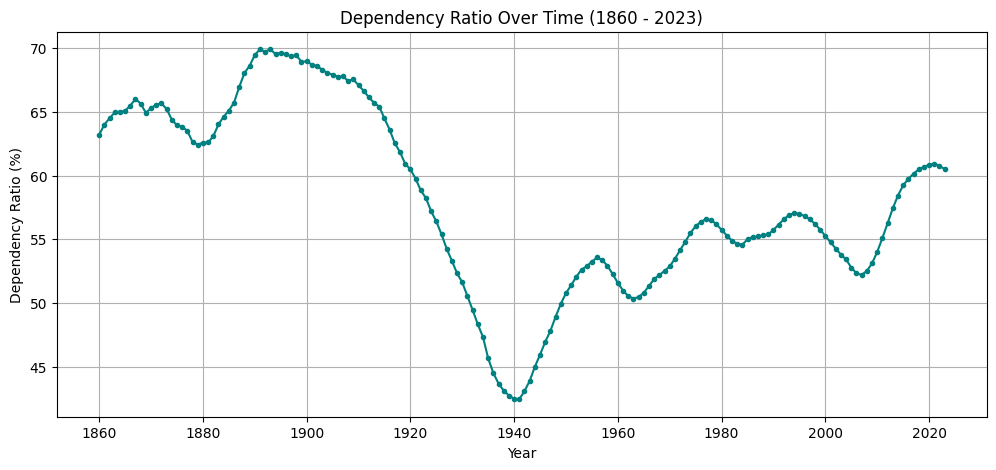

In [46]:
plt.figure(figsize= (12, 5))
plt.plot(dependency_ratio.index, dependency_ratio, marker='.', linestyle='-', color='teal')

plt.title('Dependency Ratio Over Time (1860 - 2023)')
plt.xlabel('Year')
plt.ylabel('Dependency Ratio (%)')

plt.grid(True)
plt.show()

<h4> Understanding the changing dynamics of the dependency ratio in Sweden </h4> 

To better analyze the evolving demographic trends in Sweden, I will create three additional series that provide insights into the changing relationship between different age groups over time. These new series will allow for a clearer understanding of the dynamics between dependent children, the elderly, and the total population. The following series will be constructed:

- `fraction_dependent`: This will represent the fraction of the total dependent population (children and elderly) relative to the entire population in a given year. It will be expressed as a value between 0 and 1, indicating the proportion of dependents in the population.

- `fraction_children`: This will capture the fraction of children (under the defined age) within the total population, allowing us to track how the share of young dependents has changed over time.

- `fraction_elderly`: This series will focus on the fraction of elderly individuals relative to the overall population, offering insight into how the elderly population's share has evolved as Sweden has aged.

In [44]:
total_population = combined_df['children'] + combined_df['laborforce'] + combined_df['elderly']

fraction_dependent = (combined_df['children'] + combined_df['elderly']) / total_population

fraction_children = combined_df['children'] / total_population

fraction_elderly = combined_df['elderly'] / total_population

combined_df['fraction_dependent'] = fraction_dependent
combined_df['fraction_children'] = fraction_children
combined_df['fraction_elderly'] = fraction_elderly

combined_df.reset_index(inplace=True)

combined_df[['year', 'fraction_dependent', 'fraction_children', 'fraction_elderly']]

,year,fraction_dependent,fraction_children,fraction_elderly
0,1860,0.387231,0.334988,0.052243
1,1861,0.390242,0.337052,0.053190
2,1862,0.392047,0.338274,0.053773
3,1863,0.393774,0.339517,0.054257
4,1864,0.393963,0.339892,0.054072
...,...,...,...,...
159,2019,0.377647,0.177662,0.199985
160,2020,0.378242,0.177064,0.201178
161,2021,0.378659,0.175952,0.202708
162,2022,0.377913,0.173842,0.204070


<h4>Plotting the fractioned data </h4> 

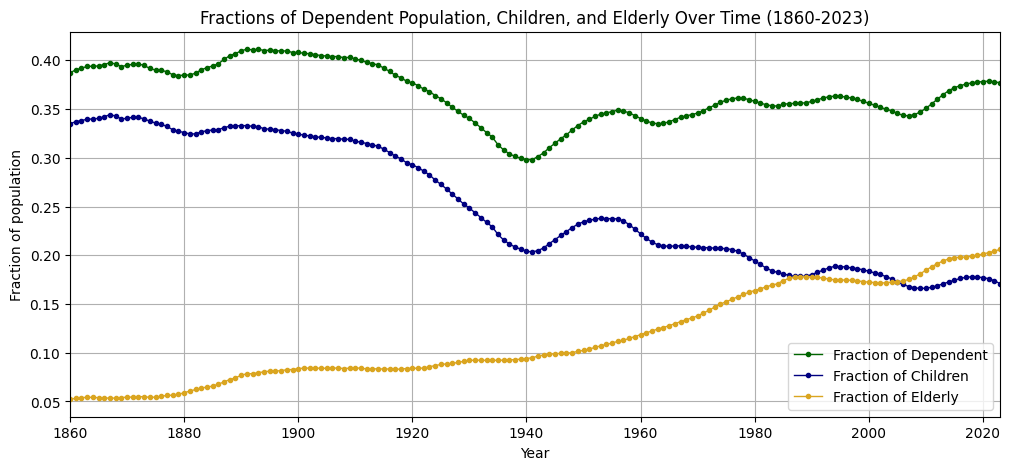

In [45]:
columns_to_plot = combined_df[['year', 'fraction_dependent', 'fraction_children', 'fraction_elderly']]

plt.figure(figsize=(12,5)) 

plt.plot(combined_df['year'], combined_df['fraction_dependent'], label='Fraction of Dependent', marker='.', color='darkgreen', linewidth=1)
plt.plot(combined_df['year'], combined_df['fraction_children'], label='Fraction of Children', marker='.', color='navy', linewidth=1)
plt.plot(combined_df['year'], combined_df['fraction_elderly'], label='Fraction of Elderly', marker='.', color='goldenrod', linewidth=1)

plt.title('Fractions of Dependent Population, Children, and Elderly Over Time (1860-2023)')
plt.xlabel('Year')
plt.ylabel('Fraction of population')

plt.legend(loc='lower right')
plt.grid(True)
plt.xlim([1860, 2023]) 

plt.show()

**Final Analysis**

The two figures capture the dynamic demographics of the Swedish population from the country’s early steps as an industrialized economy in the 1860s to the developed nation it is today. Several general population trends can be observed globally as a country industrializes, such as longer lifespans and higher birthrates. In a post-industrial economy, however, fertility rates tend to decrease due to declining birthrates, changing roles of women in society, and the prevalence of nuclear families, while life expectancy continues to increase as a result of advancements in medical knowledge and technology (Lesthaeghe, 2010; Olsson, 2001).

The data shows that up until the 1980s, the fraction of dependent children greatly exceeded the fraction of dependent elderly in Sweden. However, after the 1980s, the two dependent populations appear to level out. This shift can be attributed to two key factors: the declining fertility rates in Sweden and the increasing lifespan of the elderly population, which aligns with broader trends observed in industrialized nations (OECD, 2019; SCB, 2023). As women gained greater access to education and workforce participation in the latter half of the 20th century, fertility rates began to fall (Jonsson, 2007). Meanwhile, medical advancements and healthcare reforms contributed to longer life expectancies, particularly in elderly populations (Olsson, 2001).

One interesting data point that stands out in the figures is the steep drop in the dependency ratio during the 1940s, followed by a rapid increase. This pattern is likely a result of the Second World War and the subsequent “baby boom” that followed. This demographic shift was widely observed throughout the Western world, as fertility rates spiked during the late 1940s and early 1950s in response to economic recovery and social optimism (Patterson, 1994; SCB, 2023). The "baby boom" was a short but significant period of sharply increased birthrates, which began to stabilize by the early 1960s (Lesthaeghe, 2010).

Overall, we can conclude that while children made up the larger share of the dependent population in Sweden in the 1860s, the steady demographic changes in post-industrial Sweden suggest that the elderly population will increasingly become the primary dependent group on the labor force. With longer life expectancies and continued low fertility rates, Sweden, like many developed countries, faces the growing challenge of supporting an aging population (Eberstadt, 1995; Swedish National Institute of Public Health, 2009).

References:

Eberstadt, R. D. (1995). The Demography of Aging. In The Population of Aging (pp. 15-43). Springer.

Jonsson, L. O. (2007). The Population History of Sweden. Stockholm University Press.

Lesthaeghe, R. (2010). The Second Demographic Transition: A Conceptual Map for the Understanding of the Patterns of Change and Variation in Family Formation. Vienna Yearbook of Population Research, 8, 21-45.

Olsson, E. (2001). Health and Life Expectancy in Sweden: The Role of Health Care and Public Health Policy. Scandinavian Journal of Public Health, 29(2), 72-80.

OECD. (2019). Population and Ageing in OECD Countries. OECD Publishing.

Patterson, J. T. (1994). The Baby Boom: A Social History. Basic Books.

SCB (Statistics Sweden). (2023). Population Data: Historical Trends and Projections. Retrieved from www.scb.se

Swedish National Institute of Public Health. (2009). Ageing Populations in Sweden and Europe. Swedish National Institute of Public Health.